# Negative L1 norm prior experiment

This code attempts to learn the 16D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 16

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 5922.86767578125
iteration 0 loss 1661.3154296875


iteration 5000 loss 10.140725135803223


iteration 10000 loss 1.231247901916504


iteration 15000 loss 0.3292085528373718


iteration 20000 loss 0.13702377676963806


iteration 25000 loss 0.09642856568098068


iteration 30000 loss 0.07908885180950165


iteration 35000 loss 0.06622941792011261


iteration 40000 loss 0.05803286284208298


iteration 45000 loss 0.05232591554522514


iteration 50000 loss 0.047082822769880295


iteration 55000 loss 0.0713040828704834


iteration 60000 loss 0.039835359901189804


iteration 65000 loss 0.03730758652091026


iteration 70000 loss 0.03486296162009239


iteration 75000 loss 0.03291213884949684


iteration 80000 loss 0.031200112774968147


iteration 85000 loss 0.029609432443976402


iteration 90000 loss 0.028259364888072014


iteration 95000 loss 0.027004914358258247


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.02593798004090786


iteration 105000 loss 0.02547384798526764


iteration 110000 loss 0.024321183562278748


iteration 115000 loss 0.023426329717040062


iteration 120000 loss 0.022527961060404778


iteration 125000 loss 0.02166787162423134


iteration 130000 loss 0.020986516028642654


iteration 135000 loss 0.02014818601310253


iteration 140000 loss 0.019564203917980194


iteration 145000 loss 0.018844088539481163


iteration 150000 loss 0.01834273524582386


iteration 155000 loss 0.017804142087697983


iteration 160000 loss 0.017273148521780968


iteration 165000 loss 0.016827551648020744


iteration 170000 loss 0.016334988176822662


iteration 175000 loss 0.01594461128115654


iteration 180000 loss 0.015579774975776672


iteration 185000 loss 0.015193243511021137


iteration 190000 loss 0.014803890138864517


iteration 195000 loss 0.014496260322630405


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.014178192242980003


iteration 205000 loss 0.01402752660214901


iteration 210000 loss 0.013676407746970654


iteration 215000 loss 0.013343722559511662


iteration 220000 loss 0.013017258606851101


iteration 225000 loss 0.012720800936222076


iteration 230000 loss 0.012448773719370365


iteration 235000 loss 0.012173663824796677


iteration 240000 loss 0.011903978884220123


iteration 245000 loss 0.011643300764262676


iteration 250000 loss 0.011390904895961285


iteration 255000 loss 0.011183956637978554


iteration 260000 loss 0.010965026915073395


iteration 265000 loss 0.010755577124655247


iteration 270000 loss 0.010545398108661175


iteration 275000 loss 0.010350535623729229


iteration 280000 loss 0.010149657726287842


iteration 285000 loss 0.009959978982806206


iteration 290000 loss 0.009768483228981495


iteration 295000 loss 0.009591737762093544


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.009417280554771423


iteration 305000 loss 0.009392289444804192


iteration 310000 loss 0.009305641055107117


iteration 315000 loss 0.009210453368723392


iteration 320000 loss 0.009118890389800072


iteration 325000 loss 0.009030093438923359


iteration 330000 loss 0.008943653665482998


iteration 335000 loss 0.008859485387802124


iteration 340000 loss 0.008777089416980743


iteration 345000 loss 0.008696373552083969


iteration 350000 loss 0.008617340587079525


iteration 355000 loss 0.008539878763258457


iteration 360000 loss 0.00846385769546032


iteration 365000 loss 0.008389187045395374


iteration 370000 loss 0.008315790444612503


iteration 375000 loss 0.008243528194725513


iteration 380000 loss 0.008172429166734219


iteration 385000 loss 0.008102424442768097


iteration 390000 loss 0.00803346186876297


iteration 395000 loss 0.00796558428555727


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.007898739539086819


iteration 405000 loss 0.007892592810094357


iteration 410000 loss 0.007886074483394623


iteration 415000 loss 0.007879655808210373


iteration 420000 loss 0.007873309776186943


iteration 425000 loss 0.007867012172937393


iteration 430000 loss 0.007860779762268066


iteration 435000 loss 0.007854581810534


iteration 440000 loss 0.007848426699638367


iteration 445000 loss 0.00784229300916195


iteration 450000 loss 0.007836198434233665


iteration 455000 loss 0.007830137386918068


iteration 460000 loss 0.007824113592505455


iteration 465000 loss 0.007818104699254036


iteration 470000 loss 0.00781213166192174


iteration 475000 loss 0.007806176785379648


iteration 480000 loss 0.007800265680998564


iteration 485000 loss 0.007794352248311043


iteration 490000 loss 0.0077884807251393795


iteration 495000 loss 0.007782620377838612


L2 loss -- Plot

loss 365.5552978515625


loss 290.90545654296875


loss 267.24493408203125


loss 257.3042907714844


loss 252.81222534179688


loss 250.76275634765625


loss 249.86834716796875


loss 249.513671875


loss 249.39283752441406


loss 249.35971069335938


loss 249.35293579101562


loss 249.3520050048828


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.35194396972656


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.35191345214844


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


loss 249.3519287109375


final mse:  7.027262327596873e-09
max, min: 2.274812 -2.161885
loss 365.5552978515625


loss 289.55230712890625


loss 265.0960998535156


loss 255.12171936035156


loss 250.7765655517578


loss 248.85549926757812


loss 248.03829956054688


loss 247.72096252441406


loss 247.61460876464844


loss 247.58578491210938


loss 247.57992553710938


loss 247.57911682128906


loss 247.5790557861328


loss 247.57904052734375


loss 247.57907104492188


loss 247.5790557861328


loss 247.5790557861328


loss 247.5790557861328


loss 247.57904052734375


loss 247.5790557861328


loss 247.57904052734375


loss 247.5790557861328


loss 247.57904052734375


loss 247.5790557861328


loss 247.57904052734375


loss 247.57904052734375


loss 247.57907104492188


loss 247.5790557861328


loss 247.57904052734375


loss 247.57904052734375


loss 247.5790557861328


loss 247.5790557861328


loss 247.57904052734375


loss 247.57904052734375


loss 247.5790557861328


loss 247.5790557861328


loss 247.57907104492188


loss 247.57904052734375


loss 247.5790557861328


loss 247.57904052734375


final mse:  5.236144851039626e-09
max, min: 2.2809906 -2.0411534


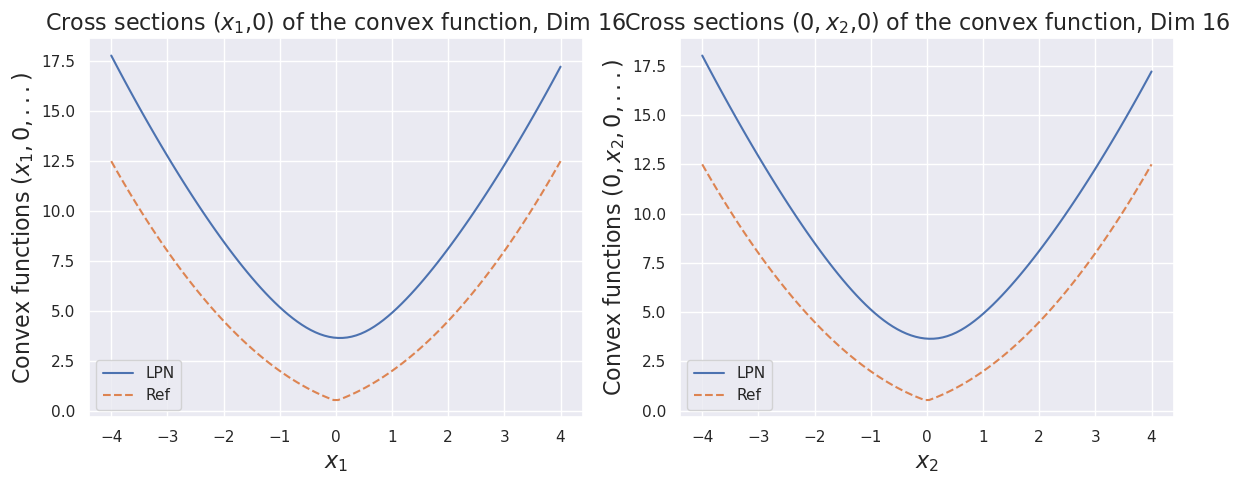

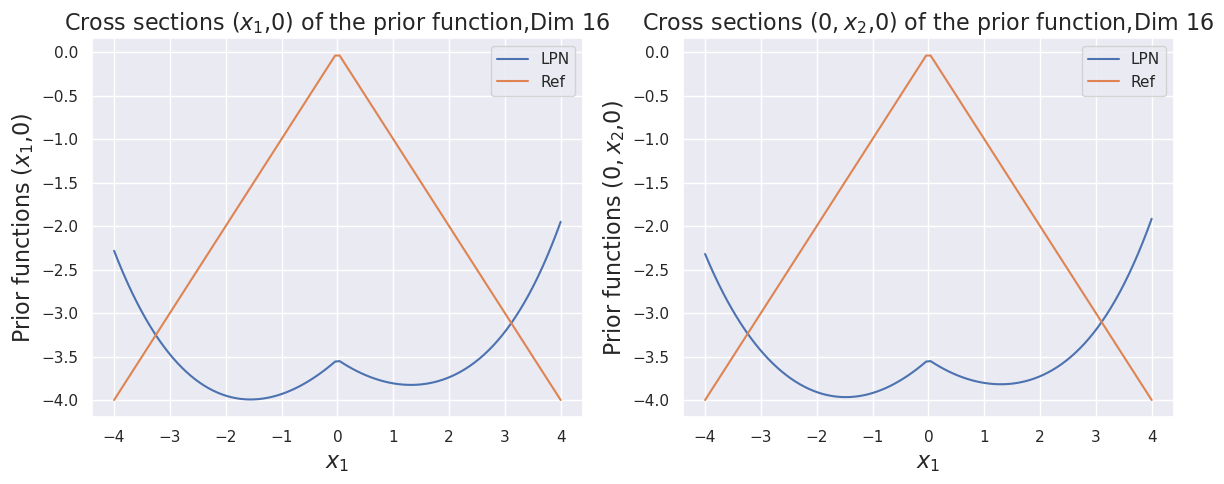

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1754.614013671875
iteration 0 loss 212.01837158203125


iteration 5000 loss 5.1753458976745605


iteration 10000 loss 0.8106873035430908


iteration 15000 loss 0.5826191902160645


iteration 20000 loss 0.4868474006652832


iteration 25000 loss 0.4287669062614441


iteration 30000 loss 0.3753027319908142


iteration 35000 loss 0.32429060339927673


iteration 40000 loss 0.2939326763153076


iteration 45000 loss 0.2698434889316559


iteration 50000 loss 0.25158023834228516


iteration 55000 loss 0.2357650101184845


iteration 60000 loss 0.22566364705562592


iteration 65000 loss 0.21514633297920227


iteration 70000 loss 0.20713594555854797


iteration 75000 loss 0.20007431507110596


iteration 80000 loss 0.19377143681049347


iteration 85000 loss 0.18792614340782166


iteration 90000 loss 0.18208864331245422


iteration 95000 loss 0.17673614621162415


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.17142832279205322


iteration 105000 loss 0.16703884303569794


iteration 110000 loss 0.1627071350812912


iteration 115000 loss 0.1585836261510849


iteration 120000 loss 0.15455186367034912


iteration 125000 loss 0.15046940743923187


iteration 130000 loss 0.1464224010705948


iteration 135000 loss 0.1422796994447708


iteration 140000 loss 0.1376745104789734


iteration 145000 loss 0.13405582308769226


iteration 150000 loss 0.13050104677677155


iteration 155000 loss 0.1270744502544403


iteration 160000 loss 0.12365084141492844


iteration 165000 loss 0.12046261876821518


iteration 170000 loss 0.11741240322589874


iteration 175000 loss 0.11443813890218735


iteration 180000 loss 0.11160171777009964


iteration 185000 loss 0.10925289988517761


iteration 190000 loss 0.10696616023778915


iteration 195000 loss 0.10474194586277008


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.10260561108589172


iteration 205000 loss 0.10197314620018005


iteration 210000 loss 0.099918894469738


iteration 215000 loss 0.09782884269952774


iteration 220000 loss 0.09581518918275833


iteration 225000 loss 0.09389892965555191


iteration 230000 loss 0.09208603948354721


iteration 235000 loss 0.09035628288984299


iteration 240000 loss 0.08869201689958572


iteration 245000 loss 0.08707021921873093


iteration 250000 loss 0.0854649618268013


iteration 255000 loss 0.08383454382419586


iteration 260000 loss 0.08220864087343216


iteration 265000 loss 0.08062431961297989


iteration 270000 loss 0.07907277345657349


iteration 275000 loss 0.07755149900913239


iteration 280000 loss 0.07607315480709076


iteration 285000 loss 0.07459688931703568


iteration 290000 loss 0.07312577962875366


iteration 295000 loss 0.07169035077095032


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.07029693573713303


iteration 305000 loss 0.07012252509593964


iteration 310000 loss 0.06993551552295685


iteration 315000 loss 0.06975392997264862


iteration 320000 loss 0.06957557052373886


iteration 325000 loss 0.06939961016178131


iteration 330000 loss 0.06922565400600433


iteration 335000 loss 0.06905288249254227


iteration 340000 loss 0.06888142973184586


iteration 345000 loss 0.06871083378791809


iteration 350000 loss 0.06854189187288284


iteration 355000 loss 0.06837384402751923


iteration 360000 loss 0.06820648163557053


iteration 365000 loss 0.068039670586586


iteration 370000 loss 0.06787335872650146


iteration 375000 loss 0.0677073746919632


iteration 380000 loss 0.06754173338413239


iteration 385000 loss 0.06737625598907471


iteration 390000 loss 0.06721093505620956


iteration 395000 loss 0.06704605370759964


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.06688127666711807


iteration 405000 loss 0.066868856549263


iteration 410000 loss 0.06685645133256912


iteration 415000 loss 0.06684408336877823


iteration 420000 loss 0.0668317899107933


iteration 425000 loss 0.06681959331035614


iteration 430000 loss 0.06680742651224136


iteration 435000 loss 0.06679531931877136


iteration 440000 loss 0.06678324937820435


iteration 445000 loss 0.06677119433879852


iteration 450000 loss 0.0667591318488121


iteration 455000 loss 0.06674712896347046


iteration 460000 loss 0.06673512607812881


iteration 465000 loss 0.06672317534685135


iteration 470000 loss 0.06671123206615448


iteration 475000 loss 0.06669929623603821


iteration 480000 loss 0.06668741255998611


iteration 485000 loss 0.06667552888393402


iteration 490000 loss 0.06666366755962372


iteration 495000 loss 0.0666518285870552


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


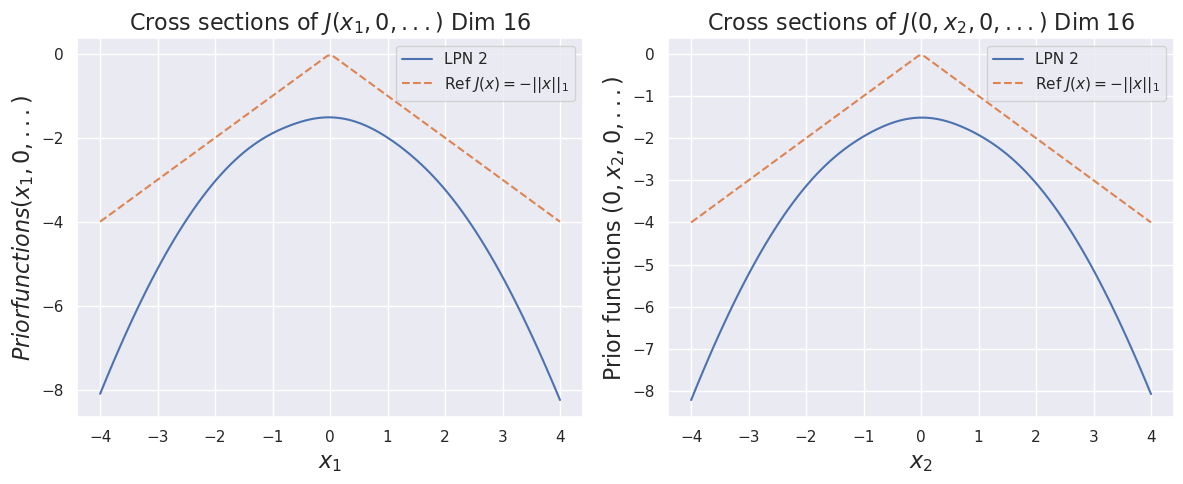

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$Prior functions (x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)